# Colorbot

**Special thanks @MarkDaoustthat helped us with this material**

In order to have a better experience follow these steps:

1. Read all the notebook, try to understand what each part of the code is doing and get familiar with the implementation;
2. For each exercise in this notebook make a copy of this notebook and try to implement what is expected. We suggest the following order for the exercises: *EXERCISE: HYPERPARAMETERS*, *EXERCISE: EXPERIMENT*, *EXERCISE: DATASET*;
3. Troubles or doubts about the code/exercises? Ask the instructor about it or go to the end of this notebook for a possible implementation/instruction for the exercises.

## Content of this notebook

In this notebook you'll find a full implementation of a RNN model using the TensorFlow Estimators including comments and details about how to do it. 

Once you finish this notebook, you'll have a better understanding of:
  * [TensorFlow Estimators](https://www.tensorflow.org/extend/estimators)
  * [TensorFlow DataSets](https://github.com/tensorflow/tensorflow/tree/r1.2/tensorflow/contrib/data)
  * [RNNs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)


## What is colorbot?

Colorbot is a RNN model that receives a word (sequence of characters) as input and learns to predict a rgb value that better represents this word. As a result we have a color generator!

![colorbot in action](../../images/colorbot_gif.gif)

## Dependencies

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Tensorflow
import tensorflow as tf
print('Expected version: 1.2.0 or higher')
print('Your TensorFlow version:', tf.__version__) 

# Feeding function for enqueue data
from tensorflow.python.estimator.inputs.queues import feeding_functions as ff

# Rnn common functions
from tensorflow.contrib.learn.python.learn.estimators import rnn_common

# Run an experiment
from tensorflow.contrib.learn.python.learn import learn_runner

# Model builder
from tensorflow.python.estimator import model_fn as model_fn_lib

# Plot images with pyplot
%matplotlib inline
from matplotlib import pyplot as plt

# Helpers for data processing
import pandas as pd
import numpy as np
import argparse

Expected version: 1.2.0 or higher
Your TensorFlow version: 1.2.1


## Parameters

In [6]:
# Data files
TRAIN_INPUT = 'data/train.csv'
TEST_INPUT = 'data/test.csv'
MY_TEST_INPUT = 'data/mytest.csv'

# Parameters for training
BATCH_SIZE = 64

# Parameters for data processing
VOCAB_SIZE = 256
CHARACTERS = [chr(i) for i in range(VOCAB_SIZE)]
SEQUENCE_LENGTH_KEY = 'sequence_length'
COLOR_NAME_KEY = 'color_name'

## Helper functions

In [7]:
# Returns the column values from a CSV file as a list
def _get_csv_column(csv_file, column_name):
    with open(csv_file, 'r') as f:
        df = pd.read_csv(f)
        return df[column_name].tolist()

# Plots a color image
def _plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

## Input function

Here we are defining the input pipeline using the [Dataset API](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/data).

One more complex transformation that we're using is called **group_by_window**, what this function does is to map each consecutive element in this dataset to a key using `key_func` and then groups the elements by key. It then applies `reduce_func` to at most `window_size` elements matching the same key. All except the final window for each key will contain `window_size` elements; the final window may be smaller.

In the code below what we're doing is using the **group_by_window** transformation to batch color names that have similar length together, this makes the code more efficient since the RNN will be unrroled (approximately) the same number of steps in each batch. This avoids that we waist space and computing time :)!

![](../../images/batch_by_length.png)
*Image from [Sequence Models and the RNN API (TensorFlow Dev Summit 2017)](https://www.youtube.com/watch?v=RIR_-Xlbp7s)*

** *EXERCISE DATASET (first complete the EXERCISE EXPERIMENT: change the input function bellow so it will just use normal padded_batch instead sorting the batches. Then run each model using experiments and compare the efficiency (time, global_step/sec) using TensorBoard.
hint: to compare the implementations using tensorboard just copy the model_dir folder of both executions to the same directory (the model dir should be different at each time you run the model) and point tensorboard to it with: tensorboard --logdir=path_to_model_dirs_par)* **

In [8]:
def get_input_fn(csv_file, batch_size, num_epochs=1, shuffle=True):
    def _parse(line):
        # each line: name, red, green, blue
        # split line
        items = tf.string_split([line],',').values

        # get color (r, g, b)
        color = tf.string_to_number(items[1:], out_type=tf.float32) / 255.0

        # split color_name into a sequence of characters
        color_name = tf.string_split([items[0]], '')
        length = color_name.indices[-1, 1] + 1 # length = index of last char + 1
        color_name = color_name.values
        
        return color, color_name, length

    def _length_bin(length, cast_value=5, max_bin_id=10):
        '''
        Chooses a bin for a word given it's length.
        The goal is to use group_by_window to group words
        with the ~ same ~ length in the same bin.

        Each bin will have the size of a batch, so it can train faster.
        '''
        bin_id = tf.cast(length / cast_value, dtype=tf.int64)
        return tf.minimum(bin_id, max_bin_id)

    def _pad_batch(ds, batch_size):
        return ds.padded_batch(batch_size, 
                               padded_shapes=([None], [None], []),
                               padding_values=(0.0, chr(0), tf.cast(0, tf.int64)))

    def input_fn():
        # https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/data
        dataset = (
            tf.contrib.data.TextLineDataset(csv_file) # reading from the HD
            .skip(1) # skip header
            .repeat(num_epochs) # repeat dataset the number of epochs
            .map(_parse) # parse text to variables
            .group_by_window(key_func=lambda color, color_name, length: _length_bin(length), # choose a bin
                             reduce_func=lambda key, ds: _pad_batch(ds, batch_size), # apply reduce funtion
                             window_size=batch_size)
        )
        
        # for our "manual" test we don't want to shuffle the data
        if shuffle:
            dataset = dataset.shuffle(buffer_size=100000)

        # create iterator
        color, color_name, length = dataset.make_one_shot_iterator().get_next()

        features = {
            COLOR_NAME_KEY: color_name,
            SEQUENCE_LENGTH_KEY: length,
        }

        return features, color
    return input_fn

In [9]:
train_input_fn = get_input_fn(TRAIN_INPUT, BATCH_SIZE)
test_input_fn = get_input_fn(TEST_INPUT, BATCH_SIZE)

Testing the input function

In [10]:
x, y = get_input_fn(TRAIN_INPUT, 1)()

with tf.Session() as s:
    print(s.run(x))
    print(s.run(y))

{'color_name': array([[b's', b'u', b'n', b'n', b'y']], dtype=object), 'sequence_length': array([5])}
[[ 0.66274512  0.72941178  0.6156863 ]]


## Creating the Estimator model

![](../../images/colorbot_model.png)

In [11]:
def get_model_fn(rnn_cell_sizes,
                 label_dimension,
                 dnn_layer_sizes=[],
                 optimizer='SGD',
                 learning_rate=0.01):
    
    def model_fn(features, labels, mode):
        
        color_name = features[COLOR_NAME_KEY]
        sequence_length = tf.cast(features[SEQUENCE_LENGTH_KEY], dtype=tf.int32) # int64 -> int32
        
        # ----------- Preparing input --------------------
        # Creating a tf constant to hold the map char -> index
        mapping = tf.constant(CHARACTERS, name="mapping")
        table = tf.contrib.lookup.index_table_from_tensor(mapping, dtype=tf.string)
        int_color_name = table.lookup(color_name)
        
        # Converting color names to one hot representation
        color_name_onehot = tf.one_hot(int_color_name, depth=len(CHARACTERS) + 1)
        
        # ---------- RNN -------------------
        # Each RNN layer will consist of a LSTM cell
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in rnn_cell_sizes]
        
        # Construct the layers
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        
        # Runs the RNN model dynamically
        # more about it at: 
        # https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
        outputs, final_state = tf.nn.dynamic_rnn(cell=multi_rnn_cell,
                                                 inputs=color_name_onehot,
                                                 sequence_length=sequence_length,
                                                 dtype=tf.float32)

        # Slice to keep only the last cell of the RNN
        last_activations = rnn_common.select_last_activations(outputs,
                                                              sequence_length)

        # ------------ Dense layers -------------------
        # Construct dense layers on top of the last cell of the RNN
        for units in dnn_layer_sizes:
            last_activations = tf.layers.dense(
              last_activations, units, activation=tf.nn.relu)
        
        # Final dense layer for prediction
        predictions = tf.layers.dense(last_activations, label_dimension)

        # ----------- Loss and Optimizer ----------------
        loss = None
        train_op = None

        if mode != tf.estimator.ModeKeys.PREDICT:    
            loss = tf.losses.mean_squared_error(labels, predictions)
    
        if mode == tf.estimator.ModeKeys.TRAIN:    
            train_op = tf.contrib.layers.optimize_loss(
              loss,
              tf.contrib.framework.get_global_step(),
              optimizer=optimizer,
              learning_rate=learning_rate)
        
        return model_fn_lib.EstimatorSpec(mode,
                                           predictions=predictions,
                                           loss=loss,
                                           train_op=train_op)
    return model_fn

** *EXERCISE HYPERPARAMETERS: try making changes to the model and see if you can improve the results.
Run the original model, run yours and compare them using Tensorboard. What improvements do you see?  
hint 0: change the type of RNNCell, maybe a GRUCell? Change the number of hidden layers, or add dnn layers.  
hint 1: to compare the implementations using tensorboard just copy the model_dir folder of both executions to the same directory (the model dir should be different at each time you run the model) and point tensorboard to it with: tensorboard --logdir=path_to_model_dirs_par)* **

In [13]:
model_fn = get_model_fn(rnn_cell_sizes=[256, 128], # size of the hidden layers
                        label_dimension=3, # since is RGB
                        dnn_layer_sizes=[128], # size of units in the dense layers on top of the RNN
                        optimizer='Adam', # changing optimizer to Adam
                        learning_rate=0.01)

estimator = tf.estimator.Estimator(model_fn=model_fn, model_dir='colorbot')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_tf_random_seed': 1, '_session_config': None, '_save_summary_steps': 100, '_model_dir': 'colorbot', '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000}


## Trainning and Evaluating

** *EXERCISE EXPERIMENT: The code below works, but we can use an experiment instead. Add a cell that runs an experiment instead of interacting directly with the estimator.  
hint 0: you'll need to change the train_input_fn definition, think about it...  
hint 1: the change is related with the for loop* **

In [14]:
NUM_EPOCHS = 40
for i in range(NUM_EPOCHS):
    print('Training epoch %d' % i)
    print('-' * 20)
    estimator.train(input_fn=train_input_fn)
    print('Evaluating epoch %d' % i)
    print('-' * 20)
    estimator.evaluate(input_fn = test_input_fn)

Training epoch 0
--------------------


/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into colorbot/model.ckpt.
INFO:tensorflow:step = 1, loss = 0.372918
INFO:tensorflow:Saving checkpoints for 23 into colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0824605.
Evaluating epoch 0
--------------------
INFO:tensorflow:Starting evaluation at 2017-08-03-15:00:38
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-23
INFO:tensorflow:Finished evaluation at 2017-08-03-15:00:39
INFO:tensorflow:Saving dict for global step 23: global_step = 23, loss = 0.0954898
Training epoch 1
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-23
INFO:tensorflow:Saving checkpoints for 24 into colorbot/model.ckpt.
INFO:tensorflow:step = 24, loss = 0.0994802
INFO:tensorflow:Saving checkpoints for 46 into colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0647639.
Evaluating epoch 1
--------------------
INFO:tenso

INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-276
INFO:tensorflow:Saving checkpoints for 277 into colorbot/model.ckpt.
INFO:tensorflow:step = 277, loss = 0.0915138
INFO:tensorflow:Saving checkpoints for 299 into colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00214087.
Evaluating epoch 12
--------------------
INFO:tensorflow:Starting evaluation at 2017-08-03-15:01:15
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-299
INFO:tensorflow:Finished evaluation at 2017-08-03-15:01:16
INFO:tensorflow:Saving dict for global step 299: global_step = 299, loss = 0.0762868
Training epoch 13
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-299
INFO:tensorflow:Saving checkpoints for 300 into colorbot/model.ckpt.
INFO:tensorflow:step = 300, loss = 0.0893422
INFO:tensorflow:Saving checkpoints for 322 into colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00229317.
Evaluating 

Training epoch 24
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-552
INFO:tensorflow:Saving checkpoints for 553 into colorbot/model.ckpt.
INFO:tensorflow:step = 553, loss = 0.052846
INFO:tensorflow:Saving checkpoints for 575 into colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00718242.
Evaluating epoch 24
--------------------
INFO:tensorflow:Starting evaluation at 2017-08-03-15:01:52
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-575
INFO:tensorflow:Finished evaluation at 2017-08-03-15:01:52
INFO:tensorflow:Saving dict for global step 575: global_step = 575, loss = 0.0558685
Training epoch 25
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-575
INFO:tensorflow:Saving checkpoints for 576 into colorbot/model.ckpt.
INFO:tensorflow:step = 576, loss = 0.0507478
INFO:tensorflow:Saving checkpoints for 598 into

INFO:tensorflow:Saving dict for global step 828: global_step = 828, loss = 0.0510266
Training epoch 36
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-828
INFO:tensorflow:Saving checkpoints for 829 into colorbot/model.ckpt.
INFO:tensorflow:step = 829, loss = 0.0241904
INFO:tensorflow:Saving checkpoints for 851 into colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0193809.
Evaluating epoch 36
--------------------
INFO:tensorflow:Starting evaluation at 2017-08-03-15:02:28
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-851
INFO:tensorflow:Finished evaluation at 2017-08-03-15:02:29
INFO:tensorflow:Saving dict for global step 851: global_step = 851, loss = 0.0489838
Training epoch 37
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-851
INFO:tensorflow:Saving checkpoints for 852 into colorbot/model.ckpt.
INFO:te

## Making Predictions

In [15]:
def predict(estimator, input_file):
    preds = estimator.predict(input_fn=get_input_fn(input_file, 1, shuffle=False))
    color_names = _get_csv_column(input_file, 'name')

    print()
    for p, name in zip(preds, color_names):
        color = tuple(map(int, p * 255))
        print(name + ',', 'rgb:', color)
        _plot_rgb(p)


INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-920
orange, rgb: (218, 101, 49)


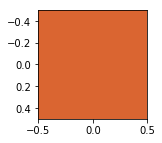

tensorflow orange, rgb: (216, 107, 51)


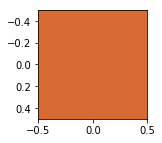

adfgasdgasd, rgb: (181, 182, 141)


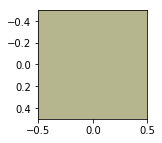

purple blue, rgb: (106, 96, 217)


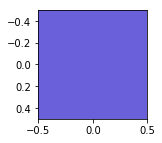

purple red, rgb: (230, 53, 102)


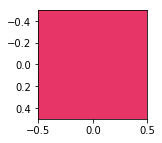

purple, rgb: (101, 23, 155)


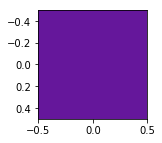

water, rgb: (207, 197, 201)


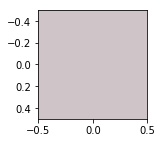

pink, rgb: (271, 151, 192)


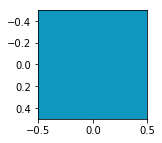

rock, rgb: (95, 54, 38)


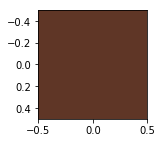

In [16]:
predict(estimator, MY_TEST_INPUT)

## Pre-trained model predictions

In order to load the pre-trained model we can just create an estimator using the model_fn and use the model_dir that contains the pre-trained model files in this case it's 'pretrained'

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_tf_random_seed': 1, '_session_config': None, '_save_summary_steps': 100, '_model_dir': 'pretrained', '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000}

INFO:tensorflow:Restoring parameters from pretrained/model.ckpt-8069
orange, rgb: (233, 124, 19)


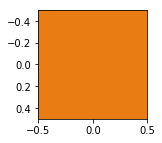

tensorflow orange, rgb: (232, 149, 88)


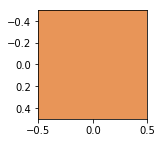

adfgasdgasd, rgb: (201, 184, 157)


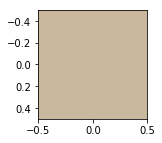

purple blue, rgb: (51, 13, 220)


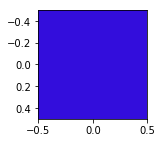

purple red, rgb: (152, 40, 61)


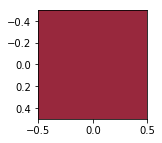

purple, rgb: (92, 23, 109)


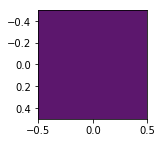

water, rgb: (160, 201, 202)


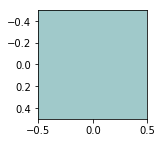

pink, rgb: (257, 153, 165)


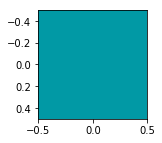

rock, rgb: (83, 65, 52)


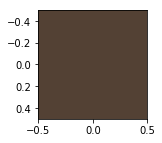

In [17]:
pre_estimator = tf.estimator.Estimator(model_dir='pretrained', model_fn=model_fn)
predict(pre_estimator, MY_TEST_INPUT)

# Colorbot Solutions 

Here are the solutions to the exercises available at the colorbot notebook.

In order to compare the models we encourage you to use Tensorboard and also use play_colorbot.py --model_dir=path_to_your_model to play with the models and check how it does with general words other than color words.

## *EXERCISE EXPERIMENT*

When using experiments you should make sure you repeat the datasets the number of epochs desired since the experiment will "run the for loop for you". Also, you can add a parameter to run a number of steps instead, it will run until the dataset ends or the number of steps.

You can add this cell to your colorbot notebook and run it.

In [ ]:
# small important detail, to train properly with the experiment you need to
# repeat the dataset the number of epochs desired
train_input_fn = get_input_fn(TRAIN_INPUT, BATCH_SIZE, num_epochs=40)

# create experiment
def generate_experiment_fn(run_config, hparams):
    estimator = tf.estimator.Estimator(model_fn=model_fn, config=run_config)
    return tf.contrib.learn.Experiment(
        estimator,
        train_input_fn=train_input_fn,
        eval_input_fn=test_input_fn
    )

learn_runner.run(generate_experiment_fn, run_config=tf.contrib.learn.RunConfig(model_dir='model_dir'))

## *EXERCISE DATASET*

0. Run the colorbot experiment and notice the choosen model_dir
1. Below is the input function definition,we don't need some of the auxiliar functions anymore
2. Add this cell and then add the solution to the EXERCISE EXPERIMENT
3. choose a different model_dir and run the cells
4. Copy the model_dir of the two models to the same path
5. tensorboard --logdir=path

In [ ]:
def get_input_fn(csv_file, batch_size, num_epochs=1, shuffle=True):
    def _parse(line):
        # each line: name, red, green, blue
        # split line
        items = tf.string_split([line],',').values

        # get color (r, g, b)
        color = tf.string_to_number(items[1:], out_type=tf.float32) / 255.0

        # split color_name into a sequence of characters
        color_name = tf.string_split([items[0]], '')
        length = color_name.indices[-1, 1] + 1 # length = index of last char + 1
        color_name = color_name.values
        return color, color_name, length

    def input_fn():
        # https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/data
        dataset = (
            tf.contrib.data.TextLineDataset(csv_file) # reading from the HD
            .skip(1) # skip header
            .map(_parse) # parse text to variables
            .padded_batch(batch_size, padded_shapes=([None], [None], []),
                               padding_values=(0.0, chr(0), tf.cast(0, tf.int64)))
            
            .repeat(num_epochs) # repeat dataset the number of epochs
        )
        
        # for our "manual" test we don't want to shuffle the data
        if shuffle:
            dataset = dataset.shuffle(buffer_size=100000)

        # create iterator
        color, color_name, length = dataset.make_one_shot_iterator().get_next()

        features = {
            COLOR_NAME_KEY: color_name,
            SEQUENCE_LENGTH_KEY: length,
        }

        return features, color
    return input_fn

As a result you will see something like:

![](../../images/colorbot_dataset_exercise_sol.png)

We called the original model "sorted_batch" and the model using the simplified input function as "simple_batch"

Notice that both models have basically the same loss in the last step, but the "sorted_batch" model runs way faster , notice the `global_step/sec` metric, it measures how many steps the model executes per second. Since the "sorted_batch" has a larger `global_step/sec` it means it trains faster. 

If you don't belive me you can change Tensorboard to compare the models in a "relative" way, this will compare the models over time. See result below.

![](../../images/colorbot_dataset_exercise_relative_sol.png)

## *EXERCISE HYPERPARAMETERS*

This one is more personal, what you see will depends on what you change in the model.
Below is a very simple example we just changed the model to use a GRUCell, just in case...

In [ ]:
def get_model_fn(rnn_cell_sizes,
                 label_dimension,
                 dnn_layer_sizes=[],
                 optimizer='SGD',
                 learning_rate=0.01):
    
    def model_fn(features, labels, mode):
        
        color_name = features[COLOR_NAME_KEY]
        sequence_length = tf.cast(features[SEQUENCE_LENGTH_KEY], dtype=tf.int32) # int64 -> int32
        
        # ----------- Preparing input --------------------
        # Creating a tf constant to hold the map char -> index
        # this is need to create the sparse tensor and after the one hot encode
        mapping = tf.constant(CHARACTERS, name="mapping")
        table = tf.contrib.lookup.index_table_from_tensor(mapping, dtype=tf.string)
        int_color_name = table.lookup(color_name)
        
        # representing colornames with one hot representation
        color_name_onehot = tf.one_hot(int_color_name, depth=len(CHARACTERS) + 1)
        
        # ---------- RNN -------------------
        # Each RNN layer will consist of a GRU cell
        rnn_layers = [tf.nn.rnn_cell.GRUCell(size) for size in rnn_cell_sizes]
        
        # Construct the layers
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        
        # Runs the RNN model dynamically
        # more about it at: 
        # https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
        outputs, final_state = tf.nn.dynamic_rnn(cell=multi_rnn_cell,
                                                 inputs=color_name_onehot,
                                                 sequence_length=sequence_length,
                                                 dtype=tf.float32)

        # Slice to keep only the last cell of the RNN
        last_activations = rnn_common.select_last_activations(outputs,
                                                              sequence_length)

        # ------------ Dense layers -------------------
        # Construct dense layers on top of the last cell of the RNN
        for units in dnn_layer_sizes:
            last_activations = tf.layers.dense(
              last_activations, units, activation=tf.nn.relu)
        
        # Final dense layer for prediction
        predictions = tf.layers.dense(last_activations, label_dimension)

        # ----------- Loss and Optimizer ----------------
        loss = None
        train_op = None

        if mode != tf.estimator.ModeKeys.PREDICT:    
            loss = tf.losses.mean_squared_error(labels, predictions)
    
        if mode == tf.estimator.ModeKeys.TRAIN:    
            train_op = tf.contrib.layers.optimize_loss(
              loss,
              tf.contrib.framework.get_global_step(),
              optimizer=optimizer,
              learning_rate=learning_rate)
        
        return model_fn_lib.EstimatorSpec(mode,
                                           predictions=predictions,
                                           loss=loss,
                                           train_op=train_op)
    return model_fn